In [1]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
import base64, pathlib
import pickle
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
with open("results/docs.pkl", "rb") as f:
    docs = pickle.load(f)

In [3]:
docs

[Document(metadata={'page': 1, 'image_id': [], 'image_path': [], 'text_summary': [], 'image_summary': []}, page_content='OECD\n\nOECD\n\nOECD Economic Outlook, Interim Report\n=====================================\n\n  \n\nFinding the Right Balance in Uncertain Times\n============================================\n\nSeptember 2025\n=============='),
 Document(metadata={'page': 3, 'image_id': [], 'image_path': [], 'text_summary': [], 'image_summary': []}, page_content='OECD Economic Outlook, Interim Report\n=====================================\n\nOECD Economic Outlook, Interim Report\n=====================================\n\nFinding the Right Balance in Uncertain Times\n============================================\n\nSeptember 2025\n==============\n\nOECD  \nBETTER POLICIES FOR BETTER LIVES'),
 Document(metadata={'page': 4, 'image_id': [], 'image_path': [], 'text_summary': [], 'image_summary': []}, page_content='This work is published under the responsibility of the Secretary-General of

In [ ]:
llm = ChatOpenAI(model_name="gpt-5-nano", temperature=0.0)
messages_multi_image = []
messages_single_image = []
for doc in docs:
    file_paths = doc.metadata["image_path"]
    context = doc.page_content

    if len(file_paths) > 1:
        image_data_arr = []
        for file_path in file_paths:
            file_path_str = "".join(file_path)
            path = pathlib.Path(file_path_str)
            image_data_arr.append(base64.b64encode(path.read_bytes()).decode("utf-8"))
            
        for idx, image_data in enumerate(image_data_arr):
            message = [
                HumanMessage(content=[
                    {"type": "text", "text": f"Here is the text of the context.{context}"},
                    {"type": "text", "text": "Describe the chart."},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_data}"}},
                ])
            ]
            response = llm.invoke(message)
            print(f"multi image {idx}")
            image_id = doc.metadata["image_id"][idx]
            doc.metadata["image_summary"].append({"image_id": image_id, "summary": response.content})

    elif len(file_paths) == 1:
        file_path_str = "".join(file_paths)
        path = pathlib.Path(file_path_str)
        image_data = base64.b64encode(path.read_bytes()).decode("utf-8")

        message = [
            HumanMessage(content=[
                {"type": "text", "text": f"Here is the text of the context.{context}"},
                {"type": "text", "text": "Describe the chart."},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_data}"}},
            ])
        ]
        response = llm.invoke(message)
        print(f"single image")
        image_id = doc.metadata["image_id"]
        doc.metadata["image_summary"].append({"image_id": image_id, "summary": response.content})

In [54]:
llm = ChatOpenAI(model_name="gpt-5-nano", temperature=0.0)

messages_for_image = []

for doc in docs:
    file_paths = doc.metadata["image_path"]
    context = doc.page_content

    if len(file_paths) > 1:
        image_data_arr = []
        for file_path in file_paths:
            file_path_str = "".join(file_path)
            path = pathlib.Path(file_path_str)
            image_data_arr.append(base64.b64encode(path.read_bytes()).decode("utf-8"))
            
        for idx, image_data in enumerate(image_data_arr):
            
            messages_for_image.append(
                {  
                    "image_id": doc.metadata["image_id"][idx],
                    "prompt":  {
                                    "role": "user",
                                    "content": [
                                        {"type": "text", "text": f"Here is the text of the context.{context}"},
                                        {"type": "text", "text": "Describe content of the image."},
                                        {
                                            "type": "image_url",
                                            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},            
                                        },
                                    ]
                                }
                }
            )
           
    elif len(file_paths) == 1:
        file_path_str = "".join(file_paths)
        path = pathlib.Path(file_path_str)
        image_data = base64.b64encode(path.read_bytes()).decode("utf-8")

        messages_for_image.append(
            {  
                "image_id": doc.metadata["image_id"],
                "prompt":  {
                                "role": "user",
                                "content": [
                                    {"type": "text", "text": f"Here is the text of the context.{context}"},
                                    {"type": "text", "text": "Describe content of the image."},
                                    {
                                        "type": "image_url",
                                        "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},            
                                    },
                                ]
                            }
            }
        )       
        


In [55]:
queries = []
for message in messages_for_image:
    queries.append([message["prompt"]])

In [56]:
res = llm.batch(queries)

In [57]:
for idx, message in enumerate(messages_for_image):
    message["image_summary"] = res[idx].content



{'image_id': [46],
 'prompt': {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Here is the text of the context.I 5\n\nI 5\n\n● Countries need to find ways of engaging co-operatively within the global trading system and  \nworking together to make trade policy more transparent and predictable while addressing economic  \nsecurity concerns.  \n· Central banks should remain vigilant and react promptly to shifts in the balance of risks to price  \nstability. Provided inflation expectations remain well anchored, policy interest rate reductions  \nshould continue in economies in which underlying inflation is projected to moderate towards target.  \nMaintaining central bank independence will preserve policy credibility and reduce the volatility and  \npersistence of inflation.  \n· Effective monitoring, supervision, and robust regulatory policies are needed to address financial  \nstability risks.  \n● Fiscal discipline is needed to safeguard longer-term debt sustainability and ma
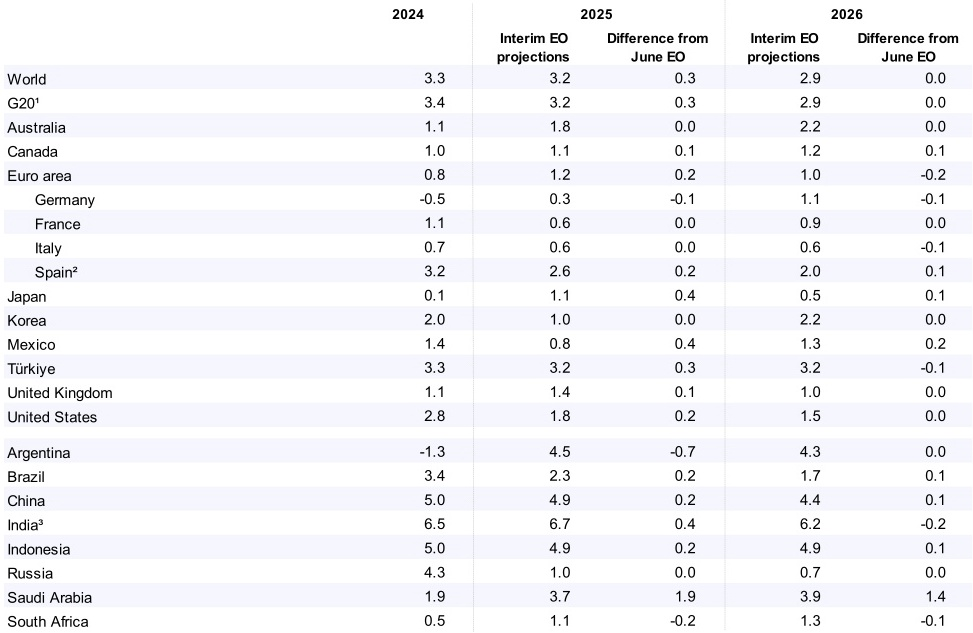

In [61]:
messages_for_image[0]

In [62]:
for doc in docs:
    for message in messages_for_image:
        if len(doc.metadata["image_id"]) == 1:
            if doc.metadata["image_id"] == message["image_id"]:
                doc.metadata["image_summary"] = message["image_summary"]
        else:
            for image_id in doc.metadata["image_id"]:
                if image_id == message["image_id"]:
                    doc.metadata["image_summary"].append(message["image_summary"])
                    


In [65]:
docs[-2].metadata["image_summary"]

['- The image contains two line charts side by side:\n  - Panel A: G20 advanced potential output growth\n  - Panel B: G20 emerging potential output growth\n- Each chart shows three growth paths from 2025 to 2050:\n  - Red line: Baseline\n  - Blue line: With structural reforms\n  - Green line: With structural reforms and faster AI adoption\n- Y-axis represents annual percentage growth (percent), and the X-axis spans from 2025 to 2050.\n- Observations:\n  - In advanced economies (Panel A), the baseline stays the lowest. Adding structural reforms raises growth moderately (blue line), and adding faster AI adoption along with reforms yields the highest growth (green line), which peaks around 2030–2035 and remains above the other paths through 2050.\n  - In emerging economies (Panel B), all paths start relatively high (around 4–5%), but the baseline declines more steeply toward the mid- to late-2040s. The reform scenario remains higher than baseline, and the combination of reforms plus faste

In [66]:
def word_count(text):
    return len(text.split())

In [67]:
word_count(docs[2].page_content)

566

In [68]:
docs[2]

Document(metadata={'page': 4, 'image_id': [], 'image_path': [], 'text_summary': [], 'image_summary': []}, page_content='This work is published under the responsibility of the Secretary-General of the OECD. The opinions expressed and  \narguments employed herein do not necessarily reflect the official views of the Member countries of the OECD.\n\nThis work is published under the responsibility of the Secretary-General of the OECD. The opinions expressed and  \narguments employed herein do not necessarily reflect the official views of the Member countries of the OECD.\n\nThis document, as well as any data and map included herein, are without prejudice to the status of or sovereignty over  \nany territory, to the delimitation of international frontiers and boundaries and to the name of any territory, city or area.\n\nThe statistical data for Israel are supplied by and under the responsibility of the relevant Israeli authorities. The use of  \nsuch data by the OECD is without prejudice to 

In [77]:
messages_for_text = []
for idx, doc in enumerate(docs):
    if word_count(doc.page_content) > 500:
        context = doc.page_content
        message = {
                    "page": doc.metadata["page"],
                    "prompt": {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": f"Here is the text of the context.{context}"},
                            {"type": "text", "text": "Summarize the text "},
                        ]
                    }
                }
            
        
        messages_for_text.append(message)
        

In [78]:
messages_for_text

[{'page': 4,
  'prompt': {'role': 'user',
   'content': [{'type': 'text',
     'text': 'Here is the text of the context.This work is published under the responsibility of the Secretary-General of the OECD. The opinions expressed and  \narguments employed herein do not necessarily reflect the official views of the Member countries of the OECD.\n\nThis work is published under the responsibility of the Secretary-General of the OECD. The opinions expressed and  \narguments employed herein do not necessarily reflect the official views of the Member countries of the OECD.\n\nThis document, as well as any data and map included herein, are without prejudice to the status of or sovereignty over  \nany territory, to the delimitation of international frontiers and boundaries and to the name of any territory, city or area.\n\nThe statistical data for Israel are supplied by and under the responsibility of the relevant Israeli authorities. The use of  \nsuch data by the OECD is without prejudice to 

In [79]:
queries_text = []
for message in messages_for_text:
    queries_text.append([message["prompt"]])

In [81]:
res_text = llm.batch(queries_text)

In [82]:
len(res_text)

13

In [83]:
res_text[0]

AIMessage(content='- The text is a copyright, licensing, and disclaimer notice for the OECD Economic Outlook, Interim Report September 2025 (Finding the Right Balance in Uncertain Times).\n- Publisher: OECD, under the responsibility of the Secretary-General; the views may not reflect all OECD member countries.\n- Territorial notes: includes standard caveats about territorial status and boundaries; specific remarks on Israel data, the Golan Heights/East Jerusalem/West Bank; notes by Turkiye and by all EU Member States of the OECD.\n- Citation: Please cite OECD (2025), OECD Economic Outlook, Interim Report September 2025: Finding the Right Balance in Uncertain Times.\n- Publication details: ISBNs for PDF and HTML, ISSNs for print and online, DOI provided; photo credit for the cover.\n- Corrigenda: corrigenda to OECD publications may be found at the publisher’s referenced page.\n- Licensing: This work is licensed under Creative Commons Attribution 4.0 International (CC BY 4.0). You must a

In [84]:
for idx, message in enumerate(messages_for_text):
    message["summary"] = res_text[idx].content 
    

In [85]:
messages_for_text[0]["page"]

4

In [86]:
for doc in docs:
    for message in messages_for_text:
        if doc.metadata["page"] == message["page"]:
            doc.metadata["text_summary"] = message["summary"]           
            


In [89]:
docs[4]

Document(metadata={'page': 6, 'image_id': [], 'image_path': [], 'text_summary': 'Here is a concise summary of the provided text:\n\n- Global growth in early 2025 was more resilient than expected, with emerging economies performing well. Front-loading demand ahead of higher tariffs and strong US AI-related investment, plus Chinese fiscal support, helped offset trade headwinds and property weakness.\n- US tariffs rose on most countries, lifting the overall effective tariff rate to about 19.5% by August, the highest since 1933. The full impact is still unfolding as changes are phased in, partly absorbed by margins, but effects are becoming visible in spending, labor markets, and prices.\n- Signs of softening in labor markets appeared in some economies, including rising unemployment and fewer job openings.\n- Disinflation has leveled off in many economies: rising food prices have boosted goods inflation, while services inflation remains persistent.\n- Financial conditions have eased recent

In [90]:
# 단계 2: 문서 분할(Split Documents)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
split_documents = text_splitter.split_documents(docs)
print(f"분할된 청크의수: {len(split_documents)}")

분할된 청크의수: 109


In [91]:
split_documents

[Document(metadata={'page': 1, 'image_id': [], 'image_path': [], 'text_summary': [], 'image_summary': []}, page_content='OECD\n\nOECD\n\nOECD Economic Outlook, Interim Report\n=====================================\n\n  \n\nFinding the Right Balance in Uncertain Times\n============================================\n\nSeptember 2025\n=============='),
 Document(metadata={'page': 3, 'image_id': [], 'image_path': [], 'text_summary': [], 'image_summary': []}, page_content='OECD Economic Outlook, Interim Report\n=====================================\n\nOECD Economic Outlook, Interim Report\n=====================================\n\nFinding the Right Balance in Uncertain Times\n============================================\n\nSeptember 2025\n==============\n\nOECD  \nBETTER POLICIES FOR BETTER LIVES'),
 Document(metadata={'page': 4, 'image_id': [], 'image_path': [], 'text_summary': '- The text is a copyright, licensing, and disclaimer notice for the OECD Economic Outlook, Interim Report Septembe

In [92]:
# 청킹 테스트 문서
delimiter = "\n\n\n" + ("---" * 50) + "\n\n\n"
split_documents_text = delimiter.join([doc.page_content for doc in split_documents])
with open("results/split_documents.txt", "w", encoding="utf-8") as f:
    f.write(split_documents_text)

In [93]:
with open('results/split_documents.pkl', 'wb') as f:
    pickle.dump(split_documents, f)